# Diffusion Example Notebook - Fashion MNIST

In [21]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as T
import numpy as np
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## Data - Fashion MNIST

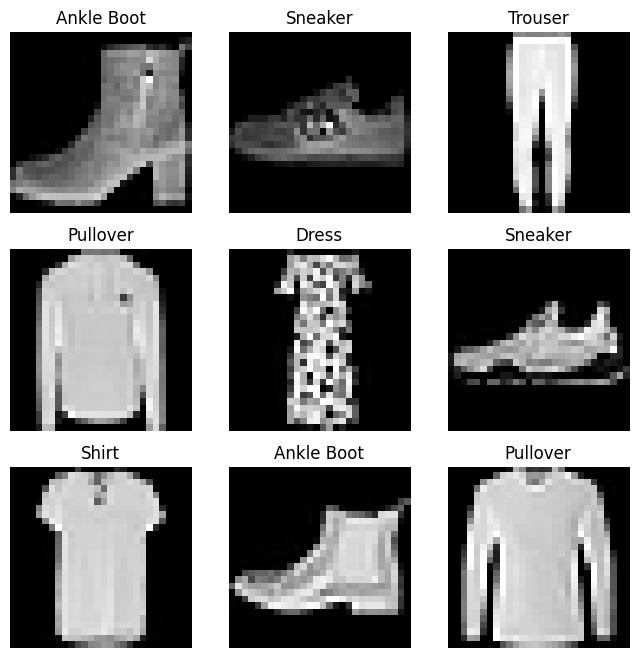

In [22]:
mean, std = 0.2860, 0.3530 

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[mean], std=[std]),
])

training_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [23]:
# Check Mean and Std
def check_mean_and_std(loader: DataLoader):
    mean = 0.
    var = 0.
    total = 0

    for data, _ in loader:
        b = data.size(0)
        imgs = data.view(b, -1)
        mean += imgs.mean(1).sum()
        var += imgs.var(1, unbiased=False).sum()
        total += b

    mean /= total
    std = torch.sqrt(var / total)
    return mean, std

mean_train, std_train = check_mean_and_std(train_dataloader)
print(f"Train Mean: {mean_train}, Train Std: {std_train}")


Train Mean: 0.00011496921069920063, Train Std: 0.9341359734535217


## Model

In [24]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(
                math.log(1.0),
                math.log(10_000.0),
                half,
                device=t.device,
                dtype=t.dtype,
            )
        )
        ang = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(ang), torch.cos(ang)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, dropout=0.0):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.activation = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.time_proj = nn.Linear(time_dim, out_ch)
        self.dropout = nn.Dropout(dropout)
        if in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.skip = nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(self.activation(self.norm1(x)))
        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = self.conv2(self.dropout(self.activation(self.norm2(h))))
        return h + self.skip(x)

class Downsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        base_channels=64,
        channel_mults=(1, 2, 4),
        num_res_blocks=2,
        time_embed_dim=256,
        num_classes=None,
        dropout=0.0,
    ):
        super().__init__()
        self.time_embed = nn.Sequential(
            SinusoidalTimeEmbedding(time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim * 4),
            nn.SiLU(),
            nn.Linear(time_embed_dim * 4, time_embed_dim),
        )
        self.label_embed = nn.Embedding(num_classes, time_embed_dim) if num_classes else None

        self.input = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)

        # Down path (blocks kept per level)
        self.down_path = nn.ModuleList()
        self.downsamples = nn.ModuleList()
        ch = base_channels
        skip_channels = []
        for level, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                blocks.append(ResidualBlock(ch, out_ch, time_embed_dim, dropout))
                ch = out_ch
                skip_channels.append(ch)
            self.down_path.append(blocks)
            if level != len(channel_mults) - 1:
                self.downsamples.append(Downsample(ch))

        # Bottleneck
        self.mid_block1 = ResidualBlock(ch, ch, time_embed_dim, dropout)
        self.mid_block2 = ResidualBlock(ch, ch, time_embed_dim, dropout)

        # Up path (mirror of down path)
        self.up_path = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        skip_channels = list(reversed(skip_channels))
        for level, mult in enumerate(reversed(channel_mults)):
            out_ch = base_channels * mult
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                skip_ch = skip_channels.pop(0)
                blocks.append(ResidualBlock(ch + skip_ch, out_ch, time_embed_dim, dropout))
                ch = out_ch
            self.up_path.append(blocks)
            if level != len(channel_mults) - 1:
                self.upsamples.append(Upsample(ch))

        self.out_norm = nn.GroupNorm(8, ch)
        self.out_conv = nn.Conv2d(ch, in_channels, kernel_size=3, padding=1)

    def forward(self, x, t, y=None):
        t_emb = self.time_embed(t)
        if self.label_embed is not None:
            if y is None:
                raise ValueError("Labels required for class-conditional model")
            t_emb = t_emb + self.label_embed(y)

        skips = []
        h = self.input(x)
        for level, blocks in enumerate(self.down_path):
            for block in blocks:
                h = block(h, t_emb)
                skips.append(h)
            if level < len(self.downsamples):
                h = self.downsamples[level](h)

        h = self.mid_block1(h, t_emb)
        h = self.mid_block2(h, t_emb)

        for level, blocks in enumerate(self.up_path):
            for block in blocks:
                skip = skips.pop()
                h = torch.cat([h, skip], dim=1)
                h = block(h, t_emb)
            if level < len(self.upsamples):
                h = self.upsamples[level](h)

        h = F.silu(self.out_norm(h))
        return self.out_conv(h)

model = UNet(in_channels=1, base_channels=64, channel_mults=(1, 2, 4), num_res_blocks=2, time_embed_dim=256, num_classes=10, dropout=0.0).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

# Test the model
data, labels = next(iter(train_dataloader))
data = data.to(device)
labels = labels.to(device)
output = model(data, torch.zeros(data.shape[0], device=device), labels)
print(output.shape)


torch.Size([64, 1, 28, 28])


## Training Loop - Denoising Diffusion Probabilistic Models

$$\mathcal{L}_{\mathrm{DDPM}}(\theta)
= \mathbb{E}_{t \sim \mathrm{Unif},\, z \sim p_{\mathrm{data}},\, \epsilon \sim \mathcal{N}(0, I_d)}
\left[ \left\| \epsilon_t^{\theta}(\alpha_t z + \beta_t \epsilon) - \epsilon \right\|^2 \right]$$

In [ ]:
T = 100 # number of diffusion steps
beta_start, beta_end = 1e-4, 2e-2

def make_linear_beta_schedule(T, beta_start, beta_end, device):
    betas = torch.linspace(beta_start, beta_end, T, device=device) # (T,)
    alphas = 1.0 - betas # (T,)
    abar = torch.cumprod(alphas, dim=0) # (T,)
    return betas, alphas, abar

betas, alphas, alpha_bar = make_linear_beta_schedule(T, beta_start, beta_end, device)

def batch(dataloader: DataLoader) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Denoising diffusion training batch.
    returns:
        xt: (n, 2) tensor of noisy data
        t: (n,) tensor of time steps
        target_noise: (n, 2) tensor of target noise
        y0: (n,) tensor of labels
    """
    x0, labels = next(dataloader)
    x0 = x0.to(device)
    labels = labels.to(device)
    gaussian_noise = torch.randn(x0.shape, device=device) # random samples (from prior, e.g. N(0,I))
    k = torch.randint(0, T, (x0.shape[0],), device=device)
    abar_k = alpha_bar[k]
    sqrt_abar = torch.sqrt(abar_k).view(-1, 1, 1, 1)
    sqrt_one_ma = torch.sqrt(1.0 - abar_k).view(-1, 1, 1, 1)
    xt = sqrt_abar * x0 + sqrt_one_ma * gaussian_noise
    t  = (k.float() + 1) / T # normalize to (0,1]; use k/T if you prefer [0,1)
    return xt, t, gaussian_noise, labels

model.train()
losses = []
steps = 3_000
loader_iter = iter(train_dataloader)
for step in range(1, steps+1):
    xt, t, target_v, y0 = batch(loader_iter)
    pred_v = model(xt, t, y0)
    loss = F.mse_loss(pred_v, target_v)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if step % 200 == 0:
        print(f"step {step}: loss {loss.item():.4f}")

plt.figure()
plt.plot(losses)
plt.title("Training Loss")
plt.show()

step 200: loss 1.0095
step 400: loss 0.9597
step 600: loss 1.0044
step 800: loss 0.9974


StopIteration: 

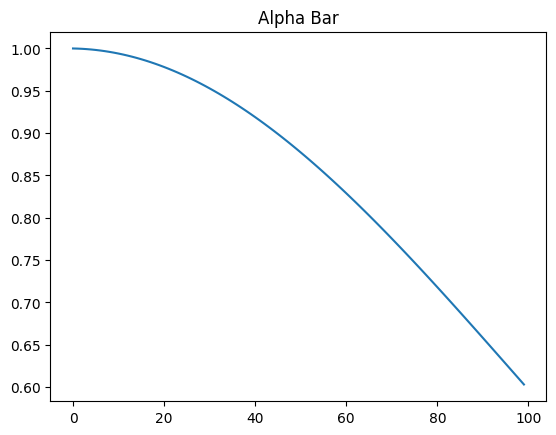

In [29]:
# Plot abar
plt.figure()
plt.plot(np.sqrt(alpha_bar.cpu().numpy()))
plt.title("Alpha Bar")
plt.show()

## Sampling

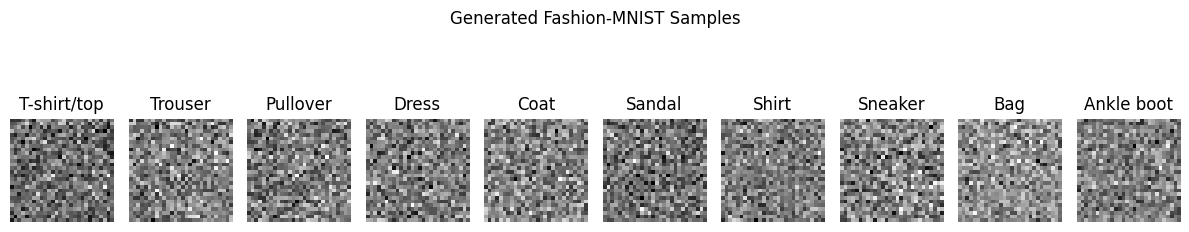

In [35]:
@torch.no_grad()
def sample(model, n, T, alpha_bar, labels=None, device="cuda"):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    if labels is None:
        labels = torch.randint(0, 10, (n,), device=device, dtype=torch.long)
    else:
        labels = labels.to(device).long()

    abar_prev = torch.ones_like(alpha_bar)
    abar_prev[1:] = alpha_bar[:-1]

    for k in reversed(range(T)):
        t_cont = torch.full((n,), (k + 1) / T, device=device)
        eps = model(x, t_cont, labels)

        abar_t = alpha_bar[k]
        abar_tm1 = abar_prev[k]

        x0_pred = (x - torch.sqrt(1 - abar_t) * eps) / torch.sqrt(abar_t)
        x = torch.sqrt(abar_tm1) * x0_pred + torch.sqrt(1 - abar_tm1) * eps  # η=0

    return x, labels


gen, labels = sample(model, 10, 100, alpha_bar, labels=torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device=device), device=device)
gen = gen.detach().cpu()
labels = labels.cpu() if labels is not None else None

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot",
]

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, img, label in zip(axes, gen, labels):
    ax.imshow(img.squeeze(), cmap="gray")
    title = class_names[label] if label is not None else "?"
    ax.set_title(title)
    ax.axis("off")

plt.suptitle("Generated Fashion-MNIST Samples")
plt.tight_layout()
plt.show()